<a href="https://colab.research.google.com/github/Remi-KC/data-course-sample/blob/main/sample_content_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Code

## 基礎建設

In [ ]:
import pandas as pd
import gzip, json
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

In [ ]:
metadata = getDF('/Users/remikc/DA/AC_DataSeed/HW/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/Users/remikc/DA/AC_DataSeed/HW/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [ ]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [ ]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [ ]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [ ]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

In [ ]:
# 利用 rank 中的類別資訊，刪除非美妝類產品，並刪除重複項
metadataB = metadata
for i in range(len(metadata)):
    if not 'Beauty' in metadata.loc[i]['rank']:
        metadataB = metadataB.drop(index = i)
metadataB.drop_duplicates('asin', inplace = True)

# 轉換 rank 資料成數字
splitR=metadataB['rank'].str.split(n=1, expand=True).rename(columns={0:'rank', 1:'cat'})
rank=splitR['rank'].replace(',','',regex=True)
rank=pd.to_numeric(rank)
metadataB = metadataB[['asin','title','description','brand','price']].join(rank)

# 轉換 price 資料成數字
splitP=metadataB['price'].str.split('$', expand=True).rename(columns={0:'none', 1:'price'})
price=splitP['price'].replace(',','',regex=True)
metadataB['price'] = pd.to_numeric(price)

## 資料切分

In [ ]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

# 篩選出近一個月購買資料
train_1m = ratings[(ratings['DATE'] >= '2018-08-01') & (ratings['DATE'] <= '2018-08-31')]

# 產生舊戶名單
reg_cus = set(users) & set(ratings_trainings['reviewerID'])


In [ ]:
#製作欲比較之商品列表 asin（前一個月被購買過的商品＋舊客戶購買過的商品(51)＝866項）
reg_cus_ = ratings_testings.merge(ratings_trainings[['reviewerID','asin']], how='left', on='reviewerID')
reg_cus_buy = reg_cus_[['reviewerID','asin_y']].rename(columns={'asin_y':'asin'}).dropna().drop_duplicates('asin')
asin = pd.concat([reg_cus_buy['asin'], train_1m['asin']]).drop_duplicates().reset_index().drop(columns=['index'])

#加入處理後商品資訊'title','rank','price'，刪除資訊不齊的品項後，共計632筆。 
asin_info = asin.merge(metadataB[['asin','title','rank','price']], how='left', on='asin').replace('', np.nan).dropna().reset_index().drop(columns=['index'])
asin_info.head() 

,asin,title,rank,price
0,B01H6W0UH2,Technic Colour Fix Cream 8 Colour Corrector Pa...,233719.0,5.99
1,B0195R1FT8,Booty Magic | Butt Enhancement Cream - 2 Month...,20807.0,39.95
2,B002OITLG0,Fairy Tales Tangle Tamer Static Free &nbsp;De...,872.0,8.40
3,B000WYJTZG,"Helen of Troy 1579 Tangle Free Hot Air Brush, ...",4421.0,28.70
4,B00NFUXX6K,Got 2B Powder'Ful Volumizing Style Powder 0.35...,6124.0,13.88


## 資料探索與特徵選擇

* 探索目的：篩選特徵
* 探索邏輯：想選出某些特徵是-商品如果在這些特徵越相近，購買數/評論數也會越接近。（賣得好的商品，有些特徵很像，同理，賣得不好的產品也是）
* 方法：計算特徵相似度後，和購買數/評論數相似度（Euclidean distance）做二級相關，看相關是否顯著。 
* 特徵：品名(title)、銷售排行(rank)、價錢(price)、評價(overall)、品牌(brand)

  
* 註：檢定部分採用permutation，比spearmanr嚴格些。


In [ ]:
# 計算每件商品的購買數/評論數
train_1m_buy=train_1m.groupby('asin').agg({'asin':'count'}).rename(columns={'asin':'count'}).reset_index()

# 計算每件商品的平均評價
rate_1m=train_1m.groupby('asin').agg({'overall':'mean'}).rename(columns={'overall':'rate'}).reset_index()

# 加入購買數和評價資料
train_1m_data=train_1m_buy.merge(rate_1m, how = 'left', on = 'asin').merge(metadataB, how = 'left', on = 'asin')


In [ ]:
# 定義 permutation 函數，這邊採用 Mantel test，用來檢定兩個矩陣的相關性
from scipy.stats import spearmanr
def _permute_func(data1, data2, random_state=None):
    
    random_state = check_random_state(random_state)

    data_row_id = range(data1.shape[0])
    permuted_ix = np.random.choice(data_row_id, size=len(data_row_id), replace=False)
    new_fmri_dist = data1.iloc[permuted_ix, permuted_ix].values
    new_fmri_dist = new_fmri_dist[np.triu_indices(new_fmri_dist.shape[0], k=1)]
    return spearmanr(new_fmri_dist, data2)[0]

In [ ]:
# 定義計算 p-value 的函數
def _calc_pvalue(all_p, stat, tail):

    denom = float(len(all_p)) + 1
    if tail == 1:
        numer = np.sum(all_p >= stat) + 1 if stat >= 0 else np.sum(all_p <= stat) + 1
    elif tail == 2:
        numer = np.sum(np.abs(all_p) >= np.abs(stat)) + 1
    else:
        raise ValueError("tail must be either 1 or 2")
    return numer / denom

In [ ]:
# 定義矩陣相關檢驗函數
from joblib import Parallel, delayed
from sklearn.utils import check_random_state
from scipy.spatial.distance import squareform
MAX_INT = np.iinfo(np.int32).max

def matrix_permutation(
    data1,
    data2,
    n_permute=5000,
    tail=2,
    n_jobs=3,
    return_perms=False,
    random_state=None,
):
    random_state = check_random_state(random_state)
    seeds = random_state.randint(MAX_INT, size=n_permute)
    sq_data1 = squareform(data1)
   
    stats = {"rho": spearmanr(data1, data2)[0]}

    all_p = Parallel(n_jobs=n_jobs)(
        delayed(_permute_func)(
            pd.DataFrame(sq_data1), data2, random_state=seeds[i]
        )
        for i in range(n_permute)
    )
    stats["p"] = _calc_pvalue(all_p, stats["rho"], tail)
    if return_perms:
        stats["perm_dist"] = all_p
    return stats

In [ ]:
# title X buy_count---sig.

train_1m_data_c = train_1m_data.dropna(subset=['title'])

# 取得 品名 的 tfidf 矩陣
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix_tm1 = tf.fit_transform(train_1m_data_c['title'])

# 計算商品間的 品名 相似程度
sim_matrix_tm1 = cosine_similarity(tfidf_matrix_tm1)

# 計算商品間的 購買數/評論數 相似程度
sim_matrix_cm1 = euclidean_distances(train_1m_data_c['count'].array.reshape(-1, 1) )

# 取矩陣的上三角形＝商品間兩兩配對相似值
sim_cm1=sim_matrix_cm1[np.triu_indices(sim_matrix_cm1.shape[0], 1)]
sim_tm1=sim_matrix_tm1[np.triu_indices(sim_matrix_tm1.shape[0], 1)]

# 計算 品名相似度 和 購買數相似度 之間的相關值：顯著
matrix_permutation(sim_cm1,sim_tm1)

{'rho': 0.03466791794973807, 'p': 0.0057988402319536095}

In [ ]:
# rank X buy_count---sig.
train_1m_data_c = train_1m_data.dropna(subset=['rank'])

# 計算商品間的 銷售排行 相似程度
sim_matrix_rm1 = euclidean_distances(train_1m_data_c['rank'].array.reshape(-1, 1) )

# 取矩陣的上三角形＝商品間兩兩配對 銷售排行 相似值
sim_rm1=sim_matrix_rm1[np.triu_indices(sim_matrix_rm1.shape[0], 1)]

# 計算 銷售排行相似度 和 購買數相似度 之間的相關值：顯著
matrix_permutation(sim_cm1,sim_rm1)

{'rho': -0.04549966978492659, 'p': 0.020595880823835233}

In [ ]:
#price X buy_count---sig.
train_1m_data_c = train_1m_data.dropna(subset=['price'])

# 計算商品間的 價錢 相似程度
sim_matrix_pm1 = euclidean_distances(train_1m_data_c['price'].array.reshape(-1, 1) )

# 取矩陣的上三角形＝商品間兩兩配對 價錢 相似值
sim_pm1=sim_matrix_pm1[np.triu_indices(sim_matrix_pm1.shape[0], 1)]

# 計算 價錢相似度 和 購買數相似度 之間的相關值：顯著
matrix_permutation(sim_cm1,sim_pm1)

{'rho': -0.06208782321542544, 'p': 0.016996600679864027}

In [ ]:
# overall(rate) X buy_count---non-sig.
train_1m_data_c = train_1m_data.dropna(subset=['rate'])

# 計算商品間的 評價 相似程度
sim_matrix_om1 = euclidean_distances(train_1m_data_c['rate'].array.reshape(-1, 1) )

# 取矩陣的上三角形＝商品間兩兩配對 評價 相似值
sim_om1=sim_matrix_om1[np.triu_indices(sim_matrix_om1.shape[0], 1)]

# 計算 評價相似度 和 購買數相似度 之間的相關值：不顯著
matrix_permutation(sim_cm1,sim_om1)

{'rho': 0.029417608649952864, 'p': 0.1349730053989202}

<AxesSubplot:xlabel='rate', ylabel='count'>

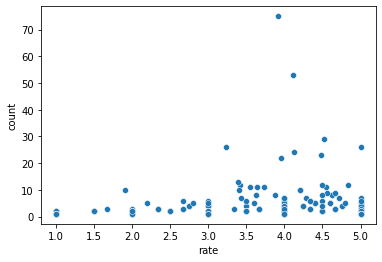

In [ ]:
# 評價 和 購買量 沒有明顯關聯
sns.scatterplot(x = train_1m_data['rate'], y= train_1m_data['count'])

<AxesSubplot:xlabel='rate', ylabel='rank'>

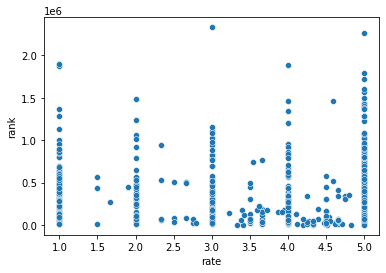

In [ ]:
# 評價 和 銷售排行 也沒有明顯關聯
sns.scatterplot(x = train_1m_data['rate'],y = train_1m_data['rank'])

In [ ]:
# brand X buy_count---non-sig.
train_1m_data_c2 = train_1m_data_c.replace('',np.nan)
train_1m_data_c2 = train_1m_data_c2.dropna(subset=['title', 'rank', 'price', 'brand'])

# 清除 品牌 裡面的符號，避免同一個牌子被歸成不同項
brand_c=train_1m_data_c2['brand']
brand_c=brand_c.replace("'",'',regex=True).replace('\.','',regex=True).replace('\(','',regex=True).replace('\)','',regex=True).replace(',','',regex=True).replace('-','',regex=True)

# 取得 品牌 的 One Hot Encoding (Dummies)
brand_dum = pd.get_dummies(brand_c , columns = ['brand'])

# 計算商品間的 品牌 相似程度
sim_matrix_bm1 = cosine_similarity(brand_dum)

# 計算商品間的 購買數/評論數 相似程度
sim_matrix_cm1 = euclidean_distances(train_1m_data_c2['count'].array.reshape(-1, 1) )

# 取矩陣的上三角形＝商品間兩兩配對 品牌、購買數 相似值
sim_bm1=sim_matrix_bm1[np.triu_indices(sim_matrix_bm1.shape[0], 1)]
sim_cm1=sim_matrix_cm1[np.triu_indices(sim_matrix_cm1.shape[0], 1)]

# 計算 品牌相似度 和 購買數相似度 之間的相關值：不顯著
matrix_permutation(sim_cm1,sim_bm1)



{'rho': 0.006710419905572132, 'p': 0.07078584283143372}

In [ ]:
# rank + price X buy_count---sig. 
train_1m_data_c = train_1m_data.dropna(subset=['title', 'rank', 'price'])

# 合併 銷售排行 和 價錢，並取標準分數
rp = train_1m_data_c[['rank', 'price']]
rp_s = StandardScaler().fit_transform(rp)

# 計算商品間的相似程度
sim_matrix_rpm1 = cosine_similarity(rp_s)
sim_matrix_cm1 = euclidean_distances(train_1m_data_c['count'].array.reshape(-1, 1) )

# 取矩陣的上三角形＝商品間兩兩配對 銷售排行＋價錢、購買數 相似值
sim_rpm1=sim_matrix_rpm1[np.triu_indices(sim_matrix_rpm1.shape[0], 1)]
sim_cm1=sim_matrix_cm1[np.triu_indices(sim_matrix_cm1.shape[0], 1)]

# 計算 銷售排行＋價錢相似度 和 購買數相似度 之間的相關值：顯著，而且變得比單一特徵更顯著
matrix_permutation(sim_cm1,sim_rpm1)

{'rho': 0.06272730697659003, 'p': 0.0001999600079984003}

In [ ]:
# title + rank + price X buy_count---sig. 
train_1m_data_c = train_1m_data.dropna(subset=['title', 'rank', 'price'])

# 取得 品名 的 tfidf 矩陣
tfidf_matrix_tm1 = tf.fit_transform(train_1m_data_c['title'])

# 合併 銷售排行 和 價錢，並取標準分數
rp = train_1m_data_c[['rank', 'price']]
rp_s = StandardScaler().fit_transform(rp)

# 合併 品名+銷售排行+價錢，取得特徵向量
vec_trpm1 = np.concatenate((np.matrix(tfidf_matrix_tm1.toarray()), rp_s), axis=1)

# 計算商品間的相似程度
sim_matrix_trpm1 = cosine_similarity(vec_trpm1)

# 取矩陣的上三角形＝商品間兩兩配對 品名+銷售排行＋價錢 相似值
sim_trpm1=sim_matrix_trpm1[np.triu_indices(sim_matrix_trpm1.shape[0], 1)]

# 計算 品名+銷售排行＋價錢相似度 和 購買數相似度 之間的相關值：顯著，較 title 單一特徵顯著，但相較 rank + price 不那麼顯著
matrix_permutation(sim_cm1,sim_trpm1)

{'rho': 0.05184770629173921, 'p': 0.0009998000399920016}

小結：
* 評價：評價相似度和購買數相似度無關，而且評價和銷售、購買數都沒有多大關係，決定不處理這個特徵，也不刪掉評價低的商品。
* 品牌：品牌相似度和購買數相似度無關，所以不處理這個特徵。
* 品名、銷售排行、價錢：這三個特徵的相似度都和購買數相似度有顯著相關，因此三個特徵都會納入評估商品相似度。


* 待測試：品名、銷售排行、價錢 三個特徵的組合方式。
 1. 品名+銷售排行+價錢
 2. 銷售排行+價錢
 3. 品名 推薦兩個，其他都推 銷售排行+價錢

## 產生推薦

In [ ]:
# 1.舊戶推薦方法一

# 特徵：品名、價錢、銷售排行
# 客戶：舊


# 計算商品用 title 所表示的 tfidf 矩陣
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix_tm1 = tf.fit_transform(asin_info['title'])

# 取得商品用 title + rank + price 所表示的特徵向量 (事先將 rank 和 price 轉成標準分數，降低測量指標不同的影響)
rp = asin_info[['rank', 'price']]
rp_s = StandardScaler().fit_transform(rp)
vec_trpm1 = np.concatenate((np.matrix(tfidf_matrix_tm1.toarray()), rp_s), axis=1)
mapping = pd.Series(asin_info.index,index = asin_info['asin'])

# 計算商品間的相似程度
sim_matrix = cosine_similarity(vec_trpm1)

# 每個商品回傳 k 個最相近的商品
def recommend_item(item_input, k=2):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(sim_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (asin_info['asin'].iloc[item_indices].tolist())
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    return res


# 只針對舊客戶，依據過去購買商品推薦相似的產品，不考慮新客戶，以評估只用內容推薦的成效。
def recommender1(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    '''
    content-based
    '''
    ratings_trainings = training_data
    recommendations = {user: recommend_items(asin_info[asin_info['asin'].isin(ratings_trainings
                       [ratings_trainings['reviewerID'] == user]['asin'].tolist())]['asin'].tolist(), k) 
                       for user in users}
    return recommendations

ratings_by_user1 = recommender1(ratings_trainings, reg_cus)

In [ ]:
# 2.舊戶推薦方法二

# 特徵：價錢、銷售排行
# 客戶：舊

# 計算商品間的相似程度
sim_matrix = cosine_similarity(rp_s)

ratings_by_user2 = recommender1(ratings_trainings, reg_cus)


In [ ]:
# 3.全部客戶推薦方法一

# 特徵：品名、價錢、銷售排行
# 客戶：新＋舊


# 計算商品間的相似程度
sim_matrix = cosine_similarity(vec_trpm1)

# 針對舊客戶採取內容推薦，新客戶採取規則推薦，若舊客戶的內容推薦數量不足則採用規則推薦。
def recommender2(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    
    
    # 計算並排序商品支持度
    score=(train_1m.groupby('asin')['overall'].size()/
         train_1m.shape[0]).to_frame().reset_index().rename(columns={"overall": "support"})
    score=score.sort_values(by=['support'], ascending=False)
    
    
    # content-based若有可用推薦品，則推薦之，若無，則推薦支持度高的產品(rule-based)至k項
    for user in users:
        
        recom = recommend_items(asin_info[asin_info['asin'].isin(ratings_trainings
            [ratings_trainings['reviewerID'] == user]['asin'].tolist())]['asin'].tolist(), k)
   
        if recom:
            recommendations[user] = recom
            
            if  k - len(recommendations[user]) > 0:
                recommendations[user].extend(score['asin'][:(k - len(recommendations[user]))])
        else:
            recommendations[user] = score['asin'][:k].tolist()
    
    return recommendations


ratings_by_user3 = recommender2(ratings_trainings, users)

In [ ]:
# 4.全部客戶推薦方法二

# 特徵：價錢、銷售排行
# 客戶：新＋舊


# 計算商品間的相似程度
sim_matrix = cosine_similarity(rp_s)


ratings_by_user4 = recommender2(ratings_trainings, users)

## 結果評估

In [ ]:
# 1.舊戶推薦方法一

# 特徵：品名、價錢、銷售排行
# 客戶：舊

# 只針對舊客戶的內容推薦評估：Recall = 0.02564 很不理想，比上週只用規則推薦的效果還差。
# 可能因為38位客戶中有高達14位沒有商品能推薦。這有可能是因為使用的商品特徵不足夠，或者顧客過去購買的商品非常冷門

dict_filter = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
ratings_testings_by_reg_cus = dict_filter(ratings_testings_by_user, reg_cus)
ratings_testings_reg_cus = pd.DataFrame(reg_cus).rename(columns={0:'reviewerID'}).merge(ratings_testings, how ='left', on='reviewerID')

def evaluate1(ratings_testings_by_reg_cus={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_reg_cus:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_reg_cus[d]))

    score = total / len(ratings_testings_reg_cus)
    return score

evaluate1(ratings_testings_by_reg_cus, ratings_by_user1)


0.02564102564102564

In [ ]:
# 2.舊戶推薦方法二

# 特徵：價錢、銷售排行
# 客戶：舊

# 只用 價錢 和 銷售排行 針對舊客戶的內容推薦評估：Recall = 0.05128 比多加上 品名 特徵好一點，但仍然比上週只用規則推薦的效果還差。
# 可能因為38位客戶中有高達14位沒有商品能推薦。這有可能是因為使用的商品特徵不足夠，或者顧客過去購買的商品非常冷門

evaluate1(ratings_testings_by_reg_cus, ratings_by_user2)


0.05128205128205128

In [ ]:
# 3.全部客戶推薦方法一

# 特徵：品名、價錢、銷售排行
# 客戶：新＋舊

# 綜合兩種推薦規則評估：Recall = 0.15254 成效提升，但應該是因為規則推薦的部分比上週優化。

def evaluate2(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate2(ratings_testings_by_user, ratings_by_user3)

0.15254237288135594

In [ ]:
# 4.全部客戶推薦方法二

# 特徵：價錢、銷售排行
# 客戶：新＋舊

# 綜合兩種推薦規則評估：Recall = 0.15423 去掉 品名 特徵後，成效微幅提升。
evaluate2(ratings_testings_by_user, ratings_by_user4)

0.15423728813559323